In [67]:
import pandas as pd
import plotly.express as px
from scipy.stats import ttest_ind as ttest
from scipy.stats import f_oneway
import numpy as np
from statsmodels.stats.power import TTestIndPower

In [17]:
hi_ic = pd.read_csv('high_ic_results.csv')
hi_ic['IC'] = 'Diluted Hi IC'
hi_ic = hi_ic[~(hi_ic['Accession'] == 'controlPos')]
hi_ic_2 = pd.read_csv('high_ic_2_results.csv')
hi_ic_2['IC'] = 'Diluted Hi IC'
hi_ic_2 = hi_ic_2[~(hi_ic_2['Accession'] == 'controlPos')]
low_ic = pd.read_csv('low_ic_results.csv')
low_ic['IC'] = 'Low IC'
low_ic_new_neg = pd.read_csv('new_low_ic_results.csv')
low_ic_new_neg['IC'] = 'Low IC - New Neg Ctrl'
low_ic_new_neg = low_ic_new_neg[low_ic_new_neg['Library Type'] == 'DNA']
low_ic_new_neg_2 = pd.read_csv('new_low_ic_results_2.csv')
low_ic_new_neg_2['IC'] = 'Low IC - New Neg Ctrl'
low_ic_new_neg_2 = low_ic_new_neg_2[low_ic_new_neg_2['Library Type'] == 'DNA']
low_ic_new_neg_remove = ['IDBD-D101028', 'IDBD-R002173', 'IDBD-R002174',
                         'IDBD-R002171', 'controlPos']
low_ic_new_neg = low_ic_new_neg[~low_ic_new_neg['Accession'].isin(low_ic_new_neg_remove)]
low_ic_new_neg_2 = low_ic_new_neg_2[~low_ic_new_neg_2['Accession'].isin(low_ic_new_neg_remove)]
# merged = pd.concat([hi_ic, low_ic], ignore_index=True)
# merged = merged.sort_values(['Batch ID', 'Run Date'])
merged_with_new_neg = pd.concat([hi_ic, hi_ic_2, low_ic, low_ic_new_neg, low_ic_new_neg_2], ignore_index=True)
merged_with_new_neg = merged_with_new_neg.drop_duplicates(['Seq Sple'])
merged_with_new_neg = merged_with_new_neg.sort_values(['Batch ID', 'Run Date'])
merged_with_new_neg['Neg Ctrl Matrix'] = 'New'
merged_with_new_neg.loc[merged_with_new_neg['Run Date'] < '2019-12-11', 'Neg Ctrl Matrix'] = 'Old'
merged_with_new_neg.loc[(merged_with_new_neg['Batch ID'].isin(['191210B02', '191211B02']))
                & (merged_with_new_neg['Accession'] == 'controlneg'), 'Neg Ctrl Matrix'] = 'Old'

/home/jmontgomery/.local/share/virtualenvs/lab_analysis-DwXlSoLZ/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




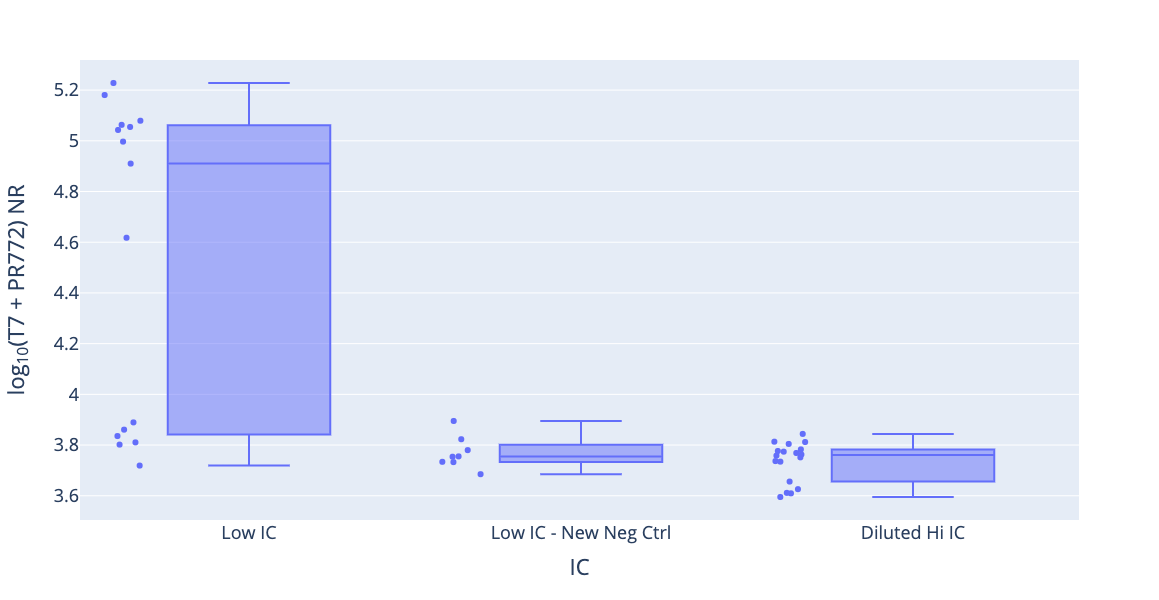

In [78]:
fig = px.box(
    merged_with_new_neg, y='Log10 T7 + PR772 NR (Composition File)',
    x='IC', hover_data=['T7 + PR772 NR (Composition File)', 'Accession', 'Sample Name', 'Batch ID', 'Run Date'], points='all',
    labels={'Log10 T7 + PR772 NR (Composition File)': 'log<sub>10</sub>(T7 + PR772) NR',
            'T7 + PR772 NR (Composition File)': 'T7 + PR772 NR'})
fig.update_layout(font=dict(size=18), height=600)
fig.show()
# fig.write_html('plots/Diluted_Hi_IC_vs_Low_IC.html')

## Equivalency of Low IC and diluted High IC

### T-test stats in log10 space

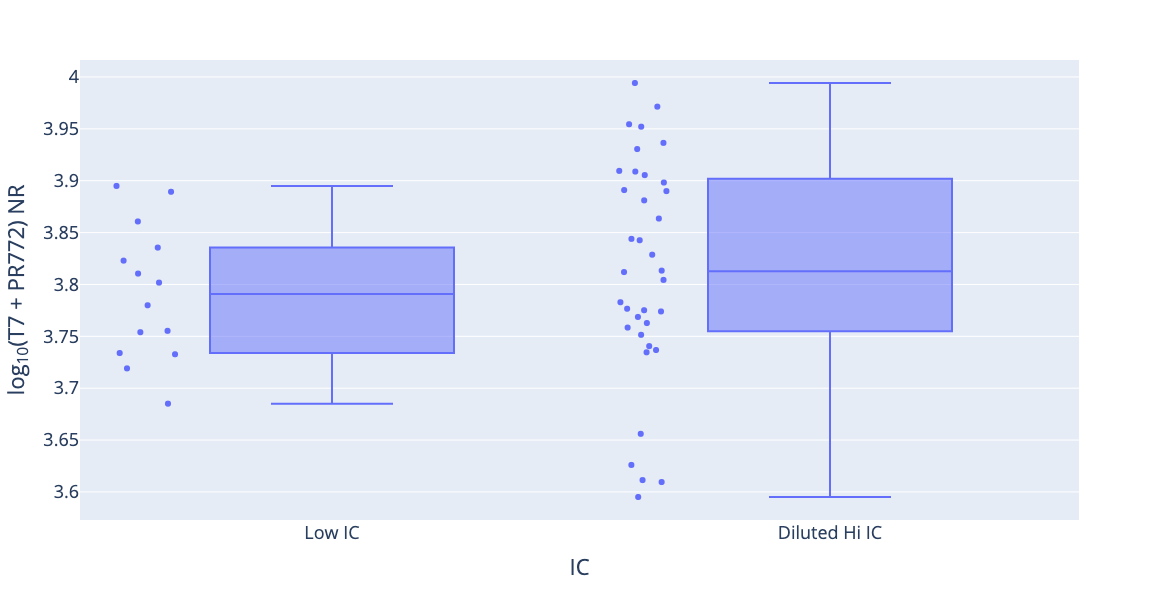

In [41]:
merged_recent = merged_with_new_neg[(merged_with_new_neg['Run Date'] > '2019-12-10') 
                                    & (merged_with_new_neg['Neg Ctrl Matrix'] == 'New')]
merged_recent = merged_recent.replace({'Low IC - New Neg Ctrl': 'Low IC'})
merged_recent['IC_2'] = merged_recent['IC'].copy()
merged_recent.loc[merged_recent['Batch ID'].isin(['200127B03', '200128B01']), 'IC_2'] = 'Diluted Hi IC Run 2'
fig = px.box(
    merged_recent, y='Log10 T7 + PR772 NR (Composition File)',
    x='IC', hover_data=['T7 + PR772 NR (Composition File)', 'Accession', 'Sample Name', 'Batch ID', 'Run Date'], points='all',
    labels={'Log10 T7 + PR772 NR (Composition File)': 'log<sub>10</sub>(T7 + PR772) NR',
            'T7 + PR772 NR (Composition File)': 'T7 + PR772 NR'})
fig.update_layout(font=dict(size=18), height=600)
fig.show()
# fig.write_html('plots/Diluted_Hi_IC_vs_Low_IC.html')

Just showing difference between the two diluted Hi-IC runs.

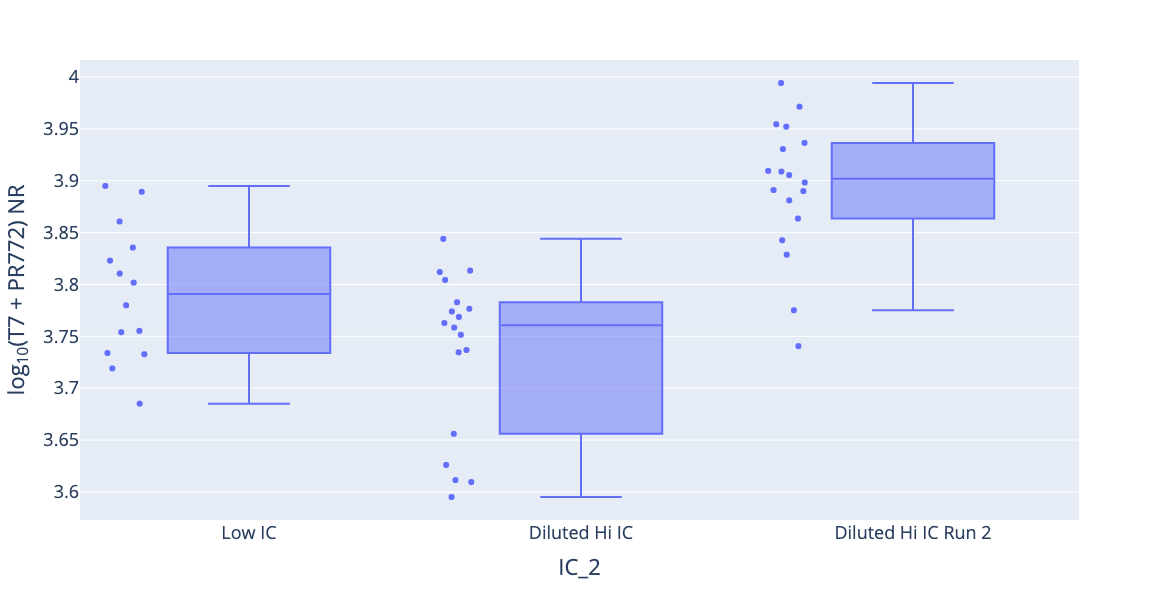

In [42]:
fig = px.box(
    merged_recent, y='Log10 T7 + PR772 NR (Composition File)',
    x='IC_2', hover_data=['T7 + PR772 NR (Composition File)', 'Accession', 'Sample Name', 'Batch ID', 'Run Date'], points='all',
    labels={'Log10 T7 + PR772 NR (Composition File)': 'log<sub>10</sub>(T7 + PR772) NR',
            'T7 + PR772 NR (Composition File)': 'T7 + PR772 NR'})
fig.update_layout(font=dict(size=18), height=600)
fig.show()
# fig.write_html('plots/Diluted_Hi_IC_vs_Low_IC.html')

In [72]:
low = merged_recent.loc[merged_recent['IC'] == 'Low IC', 'Log10 T7 + PR772 NR (Composition File)']
hi = merged_recent.loc[merged_recent['IC'] == 'Diluted Hi IC', 'Log10 T7 + PR772 NR (Composition File)']
_, pval = ttest(low, hi)
print(f"P-value for Low-IC vs Diluted High-IC in log10 space: {pval:0.2f}")
print(f"Low-IC n: {len(low)}, High-IC n: {len(hi)}")

P-value for Low-IC vs Diluted High-IC in log10 space: 0.47
Low-IC n: 14, High-IC n: 36


### ANOVA

In [73]:
low = merged_recent.loc[merged_recent['IC_2'] == 'Low IC', 'Log10 T7 + PR772 NR (Composition File)']
hi = merged_recent.loc[merged_recent['IC_2'] == 'Diluted Hi IC', 'Log10 T7 + PR772 NR (Composition File)']
hi_2 = merged_recent.loc[merged_recent['IC_2'] == 'Diluted Hi IC Run 2', 'Log10 T7 + PR772 NR (Composition File)']
f_oneway(low, hi, hi_2)

F_onewayResult(statistic=23.381755015283733, pvalue=8.943428258734331e-08)

In [76]:
print(low)

51    3.779918
52    3.753969
53    3.732711
54    3.733888
56    3.822968
57    3.685078
58    3.755276
59    3.894947
45    3.719079
46    3.801769
47    3.810478
48    3.889332
50    3.835527
49    3.860716
Name: Log10 T7 + PR772 NR (Composition File), dtype: float64


In [74]:
ttest(low, hi)

Ttest_indResult(statistic=2.180019323157966, pvalue=0.037235531864569175)

In [75]:
ttest(low, hi_2)

Ttest_indResult(statistic=-4.3909661634087245, pvalue=0.00012915015487686643)

In [54]:
np.std(hi)

0.10602924951145425

In [53]:
np.std(low)

0.06248208721087092

### Linear space

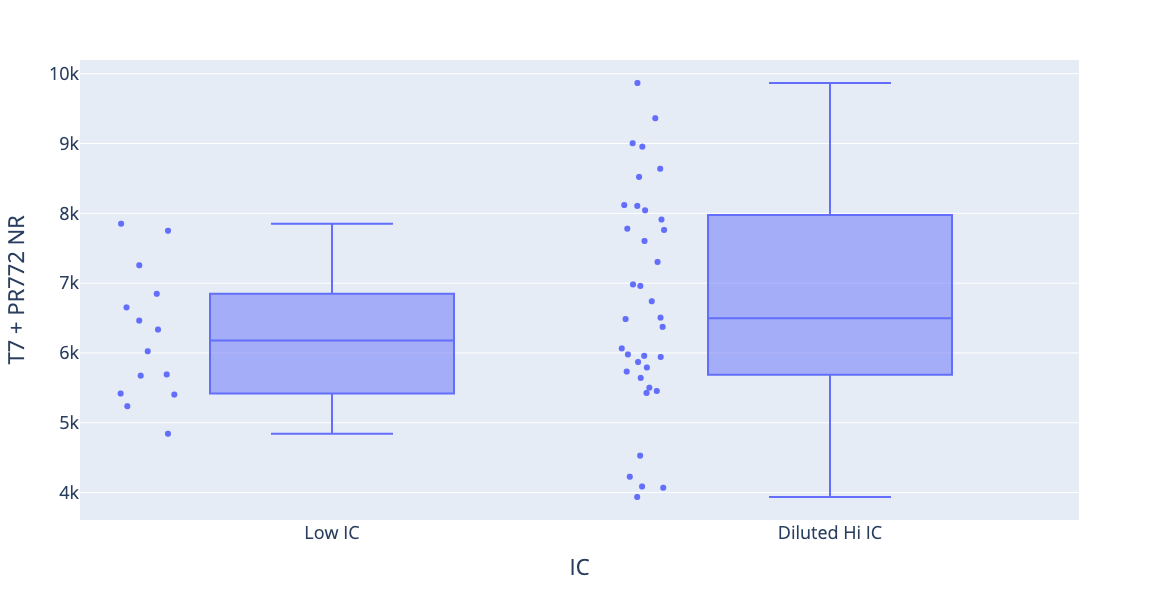

In [77]:
fig = px.box(
    merged_recent, y='T7 + PR772 NR (Composition File)',
    x='IC', hover_data=['T7 + PR772 NR (Composition File)', 'Accession', 'Sample Name', 'Batch ID', 'Run Date'], points='all',
    labels={'T7 + PR772 NR (Composition File)': '(T7 + PR772) NR',
            'T7 + PR772 NR (Composition File)': 'T7 + PR772 NR'})
fig.update_layout(font=dict(size=18), height=600)
fig.show()
# fig.write_html('plots/Diluted_Hi_IC_vs_Low_IC.html')

Again, just showing difference between first and second diluted Hi-IC runs.

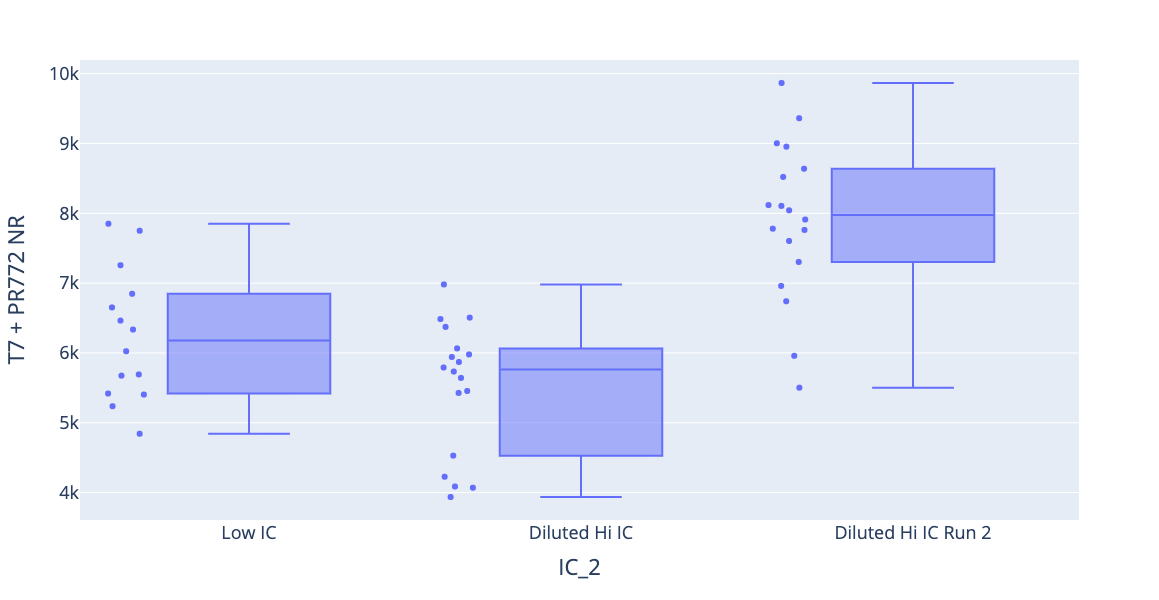

In [78]:
fig = px.box(
    merged_recent, y='T7 + PR772 NR (Composition File)',
    x='IC_2', hover_data=['T7 + PR772 NR (Composition File)', 'Accession', 'Sample Name', 'Batch ID', 'Run Date'], points='all',
    labels={'T7 + PR772 NR (Composition File)': '(T7 + PR772) NR',
            'T7 + PR772 NR (Composition File)': 'T7 + PR772 NR'})
fig.update_layout(font=dict(size=18), height=600)
fig.show()
# fig.write_html('plots/Diluted_Hi_IC_vs_Low_IC.html')

### T-test stats in linear space
Just to make sure.

In [79]:
low = merged_recent.loc[merged_recent['IC'] == 'Low IC', 'T7 + PR772 NR (Composition File)']
hi = merged_recent.loc[merged_recent['IC'] == 'Diluted Hi IC', 'T7 + PR772 NR (Composition File)']
_, pval = ttest(low, hi)
print(f"P-value for Low-IC vs Diluted High-IC in linear space: {pval:0.2f}")

P-value for Low-IC vs Diluted High-IC in linear space: 0.32


### Power analysis

In [80]:
power = TTestIndPower()
effect_size = power.solve_power(nobs1=14, ratio=(36/14), alpha=0.05, power=0.8)
print(f"An effect size of {effect_size * np.std(hi)} NR should be discernable with a power of 0.8 and alpha of 0.05")

An effect size of 1408.7956285845064 NR should be discernable with a power of 0.8 and alpha of 0.05


### ANOVA

In [81]:
low = merged_recent.loc[merged_recent['IC_2'] == 'Low IC', 'T7 + PR772 NR (Composition File)']
hi = merged_recent.loc[merged_recent['IC_2'] == 'Diluted Hi IC', 'T7 + PR772 NR (Composition File)']
hi_2 = merged_recent.loc[merged_recent['IC_2'] == 'Diluted Hi IC Run 2', 'T7 + PR772 NR (Composition File)']
f_oneway(low, hi, hi_2)

F_onewayResult(statistic=26.12719615702265, pvalue=2.3479070247961385e-08)

In [82]:
ttest(low, hi)

Ttest_indResult(statistic=2.209962970278848, pvalue=0.03487993630585356)

In [83]:
ttest(low, hi_2)

Ttest_indResult(statistic=-4.407831118485157, pvalue=0.00012320543083974974)

In [84]:
print(low)

51    6024.460948
52    5675.047209
53    5403.951341
54    5418.615710
56    6652.236668
57    4842.589013
58    5692.139847
59    7851.406422
45    5236.962858
46    6335.327852
47    6463.652569
48    7750.543808
50    6847.422829
49    7256.320680
Name: T7 + PR772 NR (Composition File), dtype: float64


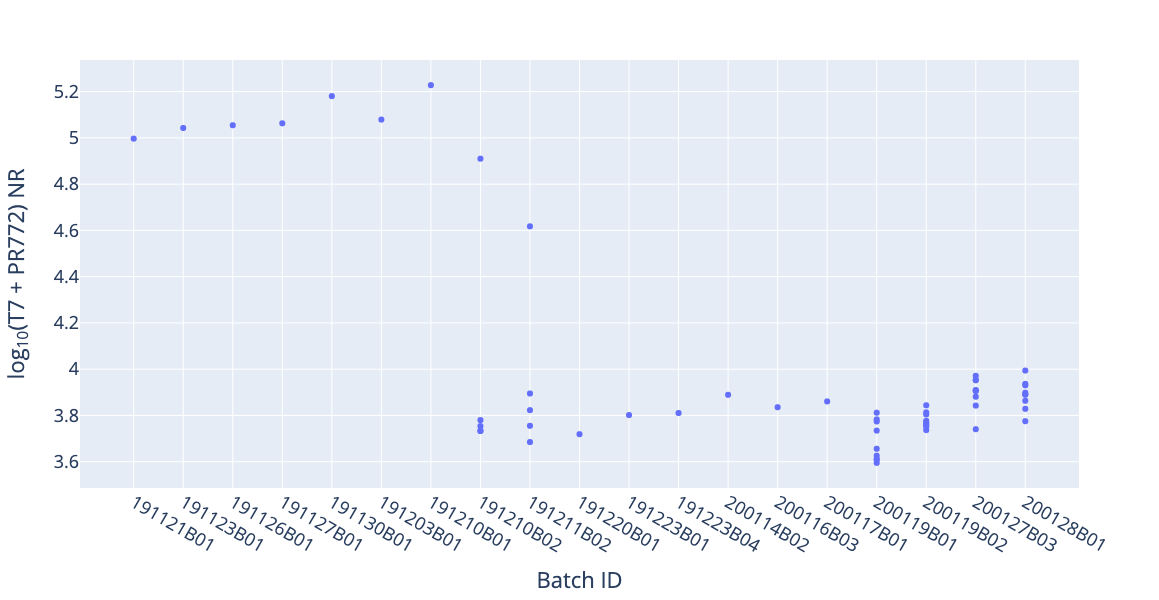

In [47]:
fig = px.scatter(
    merged_with_new_neg, y='Log10 T7 + PR772 NR (Composition File)',
    x='Batch ID',
    labels={'Log10 T7 + PR772 NR (Composition File)': 'log<sub>10</sub>(T7 + PR772) NR',
            'T7 + PR772 NR (Composition File)': 'T7 + PR772 NR'},
    hover_data=['T7 + PR772 NR (Composition File)', 'Accession', 'Run Date']
)
fig.update_layout(font=dict(size=18), height=600)
fig.show()
fig.write_html('plots/Diluted_Hi_IC_vs_Low_IC_by_batch.html')

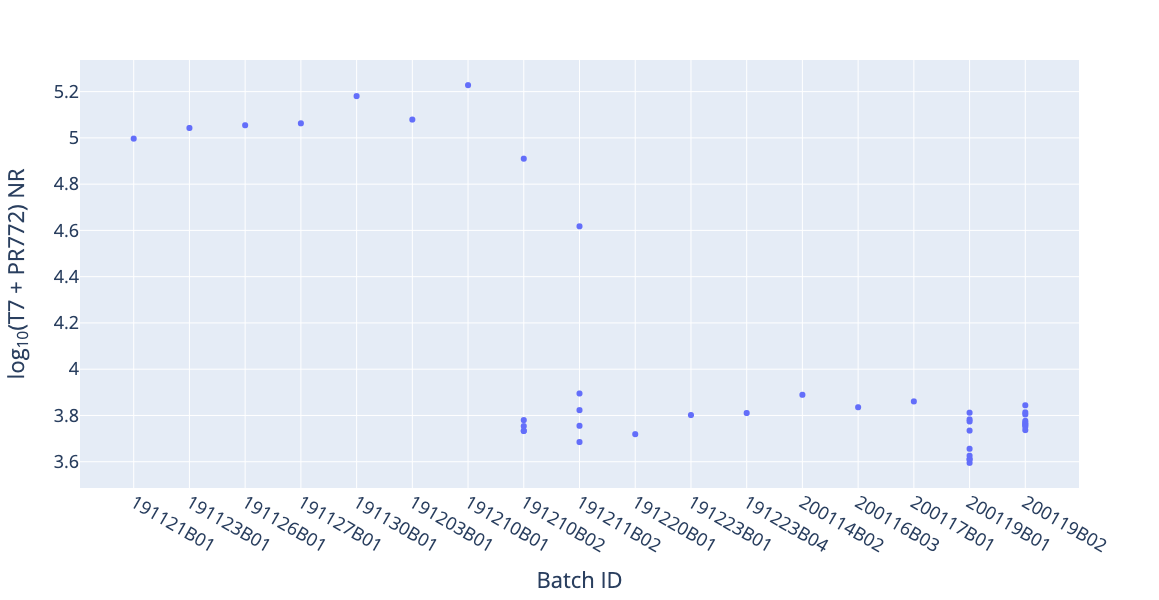

In [82]:
fig = px.scatter(
    merged_with_new_neg, y='Log10 T7 + PR772 NR (Composition File)',
    x='Batch ID',
    labels={'Log10 T7 + PR772 NR (Composition File)': 'log<sub>10</sub>(T7 + PR772) NR',
            'T7 + PR772 NR (Composition File)': 'T7 + PR772 NR'},
    hover_data=['T7 + PR772 NR (Composition File)', 'Accession', 'Run Date']
)
fig.update_layout(font=dict(size=18), height=600)
fig.show()
fig.write_html('plots/Diluted_Hi_IC_vs_Low_IC_by_batch.html')

In [83]:
merged_with_new_neg.columns

Index(['Accession', 'Bacteria', 'Batch ID', 'Composition File', 'Fungus',
       'Human', 'IC', 'Library Type', 'Log10 T7 + PR772 NR',
       'Log10 T7 + PR772 NR (Composition File)', 'PR772 Normalized Reads',
       'PR772 Raw Reads', 'Parasite', 'Run Date', 'Sample Name', 'Seq Sple',
       'Summary - Composition (log10)', 'T4 Normalized (Composition File)',
       'T4 Raw Reads (Composition File)', 'T7 + PR772 NR',
       'T7 + PR772 NR (Composition File)', 'T7 Normalized (Composition File)',
       'T7 Normalized Reads', 'T7 Raw Reads',
       'T7 Raw Reads (Composition File)', 'Total Reads',
       'Total Reads (Composition File)', 'Unclassified', 'Virus'],
      dtype='object')

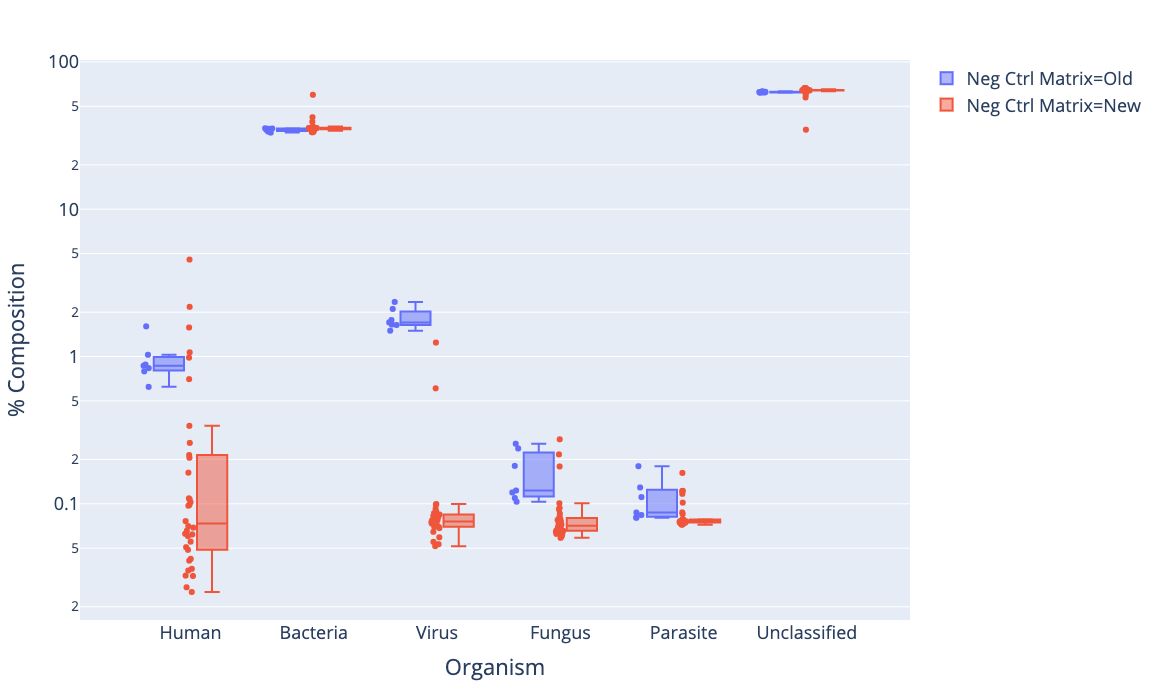

DNA    156
Name: Library Type, dtype: int64


In [87]:
merged_melt = pd.melt(
    merged_with_new_neg,
    id_vars=['Accession', 'Batch ID', 'Run Date', 'Library Type', 'Composition File'],
    value_vars=['Human', 'Bacteria', 'Virus', 'Fungus', 'Parasite', 'Unclassified'],
    value_name='% Composition',
    var_name='Organism'
)
merged_melt['Neg Ctrl Matrix'] = 'New'
merged_melt.loc[merged_melt['Run Date'] < '2019-12-11', 'Neg Ctrl Matrix'] = 'Old'
merged_melt.loc[(merged_melt['Batch ID'].isin(['191210B02', '191211B02']))
                & (merged_melt['Accession'] == 'controlNeg'), 'Neg Ctrl Matrix'] = 'Old'
merged_melt = merged_melt.sort_values('Run Date')
fig = px.box(merged_melt, x='Organism', y='% Composition',
             color='Neg Ctrl Matrix', log_y=True,
             category_orders={'Organism': ['Human', 'Bacteria', 'Virus', 'Fungus', 'Parasite', 'Unclassified']},
             points='all', hover_data=['Run Date'])
fig.update_layout(height=700, font=dict(size=18))
fig.show()
print(merged_melt['Library Type'].value_counts())